## LDPC + RL
This notebook will contain experiments conducted as part of the work done for ITW 2024 submissions 

In [1]:
%pylab inline 
import matlab
import numpy as np
import scipy as sp
import networkx as nx 
import matlab.engine
from utils import *
MATLAB = matlab.engine.start_matlab()
initial = 0

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


The parity check matrix used here is the 5G NR base matrix;

The `SubMatrix` is represented by:

In [2]:
if initial == 0:
    MATLAB.eval("addpath('LDPC_Matlab'); cd 'LDPC_Matlab/'; setup;",nargout=0)
    initial = 1

Z = int(MATLAB.workspace['Z'])
h_submatrix = array(MATLAB.workspace['H'], dtype=int)
m,n = shape(h_submatrix)

In [3]:
H = SubMatrix2PCM(h_submatrix, Z)
M,N = shape(H)
h = sp.sparse.csr_array(H)
G = nx.bipartite.from_biadjacency_matrix(h)

In [5]:
check_nds, var_nds = nx.bipartite.sets(G)

K =  6
a = list(nx.simple_cycles(G,K))
a = [cyc for cyc in a if len(cyc) == K] #filtering for K cycles
b = []
for cyc in a:
    if cyc[0] >= M:
        b.append(cyc[1:] + [cyc[0]])
    else:
        b.append(cyc)

In [ ]:
# SANITY CHECK
# len(b)
# checjs = set()
# for cyc in b:
#     for node in cyc:
#         checjs.add(node)

# len(checjs)

In [6]:
# Clustering check 
clusters = cluster_form(2, b, 6, M)
clusters

{0: [0, 4],
 1: [5, 7],
 2: [8, 10],
 3: [1, 6],
 4: [9, 11],
 5: [2, 12],
 6: [3, 13],
 7: [14, 21],
 8: [15, 20],
 9: [16, 23],
 10: [17, 22],
 11: [18, 25],
 12: [19, 24],
 13: [29, 30],
 14: [26, 31],
 15: [27, 32],
 16: [28, 33],
 17: [34, 46],
 18: [35, 47],
 19: [36, 48],
 20: [37, 49],
 21: [38, 40],
 22: [39, 41],
 23: [45, 50],
 24: [51, 61],
 25: [42, 52],
 26: [43, 53],
 27: [44, 54],
 28: [55, 63],
 29: [56, 62],
 30: [57, 65],
 31: [58, 60],
 32: [59, 67],
 33: [68, 69],
 34: [70, 85],
 35: [71, 86],
 36: [72, 87],
 37: [64, 73],
 38: [74, 89],
 39: [66, 75],
 40: [76, 81],
 41: [77, 82],
 42: [78, 83],
 43: [79, 84],
 44: [100, 110],
 45: [101, 111],
 46: [102, 112],
 47: [103, 113],
 48: [104, 114],
 49: [105, 115],
 50: [88, 106],
 51: [107, 117],
 52: [80, 108],
 53: [109, 119],
 54: [90, 94],
 55: [120, 121],
 56: [138, 140],
 57: [142, 150],
 58: [160, 165],
 59: [168, 170],
 60: [91, 95],
 61: [122, 139],
 62: [141, 143],
 63: [151, 161],
 64: [166, 169],
 65: [171

In [7]:
num_clusters = len(clusters)

# clusters = dict(clusters) already a dictionary 
vns_in_cluster = { cluster_idx: NeighborVN(cluster, G, M) for cluster_idx, cluster in clusters.items() }

MATLAB.workspace['num_clusters'] = matlab.int64(num_clusters)

# create cell arrays for irregular sets of check nodes/ bit nodes 
MATLAB.eval("clusters = cell(num_clusters,1);", nargout=0)
MATLAB.eval("vns_in_cluster = cell(num_clusters,1);", nargout=0)

for i in range(num_clusters):
    MATLAB.eval("clusters" + "{" + str(i+1) + "} = " + str(array(clusters[i]) + 1), nargout=0) 
    MATLAB.eval("vns_in_cluster" + "{" + str(i+1) + "} = " + str(array(vns_in_cluster[i]) + 1), nargout=0)

MATLAB.eval("save('Imp.mat')",nargout=0)

#### RELDEC Algorithm 

prerequisites:
-   Cycle maximizing algorithm that allocates clusters of size `z` from `m` bitnodes ::tick!::
-   State space representation of CNs (and hence neighbouring VNs)

The plan is to keep the original indices intact so that the order of nodes through which states get updated can be kept constant. 

All the RL steps can be accomplished through python structures 


All the BP local flooding computations can be done on MATLAB scripts that support this notebook

##### Deprecated RELDEC code:

In [ ]:


# k_max = int(MATLAB.eval("max(sum(a~=-1, 2)')"))  # max number of varnodes per parity check eq  
# z = 2
# tau = int(ceil(m/z))
# _l_max = 50
# epsilon = 0.7

# # clusters = cluster_form(81, b, 6, M)
# clusters = cluster_form(z, b, 6, M)

# A = [i for i in range(tau)] 

# S = {} 

# Q = zeros((2**(z*k_max), tau))

# # import L from matlab
# MATLAB.eval("load('./LDPC_M/L_dataset.mat');", nargout =0)
# L = array(matlab.double(MATLAB.workspace['L']))
# C = array(matlab.double(MATLAB.workspace['C']))

# ndata = shape(L)[0]



# # RELDEC 
# for idx in range(ndata):
#     l = L[idx,:]
#     c = C[idx,:]

#     _l = 0
#     L_hat_l = l

#     # initialize S
    
#     for cluster_idx, cluster in clusters.items():
#         S.update({cluster_idx: int_m(l[NeighborVN(cluster)] < 0)})

#     while _l < _l_max:

#         # happens with probability epsilon 
#         if random.random() <= epsilon:
#             a = np.random.randint(0,tau)
#         else:
#             a = argmax(Q[list(S.keys()), :], axis=0)
        
#         cluster_a = clusters[a]
#         vns_at_cluster = NeighborVN(cluster_a)
#         l_a = len(vns_at_cluster)

#         MATLAB.workspace['curr_clust'] = matlab.double(cluster_a)
#         l_hat, CNarray, VNarray = MATLAB.local_flood(nargout=0)

#         x_hat_a = (l_hat[vns_at_cluster] < 0)*1
#         s_a = int_m(x_hat_a)
    
#         Reward = (1/l_a)*sum(x_hat_a == c[vns_at_cluster])
        
        

#         _l += 1

In [29]:
AA = nx.adjacency_matrix(G)
# full(AA)
AA = AA.todense()

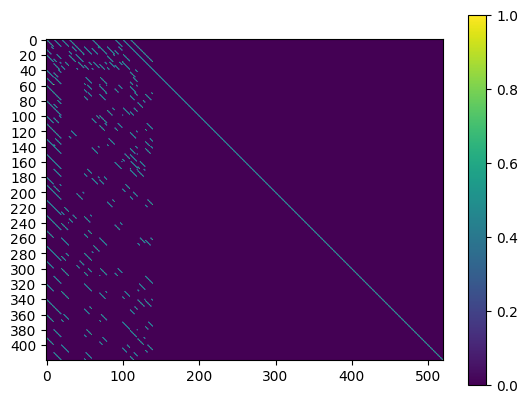

In [27]:
plt.imshow(H)
plt.yticks([x for x in range(0,420,20)])
colorbar()

In [61]:
Adj = zeros((520,520))
for i in range(42):
    for j in range(10):
        cNs = BitsinCheck(h_submatrix[i,:],10,j)
        num = i*10 + j + 100
        cNs.remove(num)
        for thing in cNs:
            Adj[num, cNs] = 1
            Adj[cNs, num] = 1

In [62]:
sum(Adj - Adj.T)

0.0

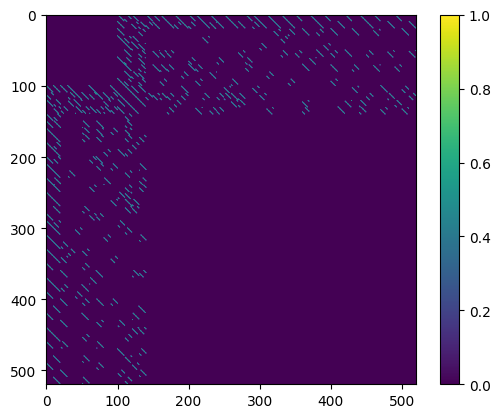

In [64]:
plt.imshow(Adj)
# plt.yticks([x for x in range(0,420,20)])
colorbar()

In [66]:
where(Adj[100,:] == 1)

(array([  0,  10,  20,  30,  60,  90, 110, 115, 130, 134, 165, 216, 261,
        343, 406, 470], dtype=int64),)

$$
l_{max} = 3  \\
\epsilon = 0.7 \\
\alpha = 0.1  \\
\beta = 0.9  \\
$$


$$Q_{l=0+1} (s_{a}^{\left(l\right)} = 4, a = 2) = (1- \alpha) Q_{l=0} (s_{a}^{\left(l\right)} = 4, a = 2)  + \alpha*( R_a +  \beta \max_{a' \in [[\tau]]]}(Q_{\left(l=0\right)} (s_{a}^{\left(l\right)'}=0, a'))) $$